In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import time as time

In [12]:
def train_loop(dataloader, model, loss_fn, optimizer, train_loss_history):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        l2_lambda = 0.001
        l2_norm = sum(p.pow(2.0).sum()
                  for p in model.parameters())

        loss = loss + l2_lambda * l2_norm


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 2000 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    train_loss_history.append(loss.item())
    return train_loss_history


def test_loop(dataloader, model, loss_fn, loss_history, accuracy_history):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    loss_history.append(test_loss)
    correct /= size
    accuracy_history.append(100*correct)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return loss_history, accuracy_history

In [13]:
batch_size = 16
learning_rate = 0.001

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), transforms.RandomHorizontalFlip(0.5)])

train_dataset = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.stack = nn.Sequential(
        nn.Conv2d(3,8,3,padding=1),
        nn.ReLU(),
        nn.Conv2d(8,16,3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.BatchNorm2d(16),

        nn.Conv2d(16,32,3,padding=1),
        nn.ReLU(),
        nn.Conv2d(32,64,3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.BatchNorm2d(64),

        nn.Conv2d(64, 128, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(128,256,3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.BatchNorm2d(256),

        nn.Flatten(),
        nn.Linear(4096, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    )

  def forward(self, x):
      x = self.stack(x)
      return x  

model = Net()

Files already downloaded and verified
Files already downloaded and verified


In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum= 0.9)

In [15]:
epoch = []
test_loss_history = []
train_loss_history = []
accuracy_history = []

epochs = 10

start = time.time()

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer, train_loss_history)
    test_loop(test_loader, model, loss_fn, test_loss_history,accuracy_history)
    epoch.append(t)

finish = time.time()
total = finish - start
total_m, total_s = divmod(total, 60)

print(total_m, "m", round(total_s,4), "s")
print("Done!")

Epoch 1
-------------------------------
loss: 3.001441  [    0/50000]
loss: 1.527062  [32000/50000]
Test Error: 
 Accuracy: 69.1%, Avg loss: 0.897913 

Epoch 2
-------------------------------
loss: 1.332021  [    0/50000]
loss: 1.093120  [32000/50000]
Test Error: 
 Accuracy: 74.3%, Avg loss: 0.737567 

Epoch 3
-------------------------------
loss: 0.948011  [    0/50000]
loss: 1.186649  [32000/50000]
Test Error: 
 Accuracy: 77.3%, Avg loss: 0.660449 

Epoch 4
-------------------------------
loss: 1.258142  [    0/50000]
loss: 0.777339  [32000/50000]
Test Error: 
 Accuracy: 77.7%, Avg loss: 0.661692 

Epoch 5
-------------------------------
loss: 1.150262  [    0/50000]
loss: 1.388569  [32000/50000]
Test Error: 
 Accuracy: 79.5%, Avg loss: 0.602214 

Epoch 6
-------------------------------
loss: 1.360947  [    0/50000]
loss: 0.819224  [32000/50000]
Test Error: 
 Accuracy: 80.5%, Avg loss: 0.577336 

Epoch 7
-------------------------------
loss: 0.875996  [    0/50000]
loss: 0.983365  [3

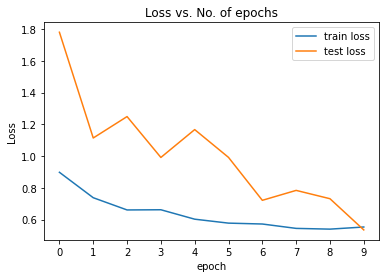

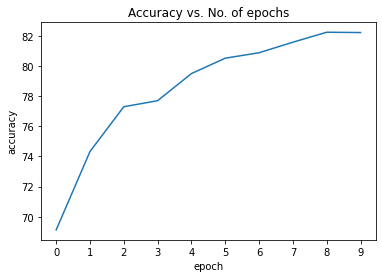

In [16]:
def plot_loss(history, history2, epoch):
    
    plt.figure(1)
    train_accuracies = [x for x in history]
    test_accuracies = [y for y in history2]
    plt.plot(epoch, train_accuracies, label = "train loss")
    plt.plot(epoch, test_accuracies, label = "test loss")

    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. No. of epochs');
    plt.locator_params('x', nbins=len(history))
    plt.locator_params('x', nbins=len(history2))

    plt.legend()

def plot_accuracy(history, epoch):
  plt.figure(2)
  accuracies = [x for x in history]
  plt.plot(epoch, accuracies, label = "accuracy")

  plt.xlabel("epoch")
  plt.ylabel("accuracy")
  plt.title("Accuracy vs. No. of epochs")
  plt.locator_params('x',nbins=len(history))
  

plot_loss(test_loss_history , train_loss_history, epoch)
plot_accuracy(accuracy_history, epoch)